In [8]:
import pandas as pd 
import os
import gc
from tqdm import tqdm
from utils import reduce_mem, uAUC, get_logger
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 预处理数据集

In [4]:
hist_data_path = "data/traindata/history_behavior_data/"
hist_df_list = []
for file in tqdm(sorted(os.listdir(hist_data_path))):
    tmp_path = hist_data_path + file
    tmp_path = tmp_path + '/' + os.listdir(tmp_path)[0]
    tmp_df = pd.read_csv(tmp_path, sep='\t', low_memory=False)
    del tmp_df['watch_start_time']
    hist_df_list.append(tmp_df)
    del tmp_df
    gc.collect()

train = pd.concat(hist_df_list, ignore_index=True)
print(train.shape)
train = reduce_mem(train, train.columns)
test = pd.read_csv("data/testdata/test.csv")
print(train.shape, test.shape)

user_info = pd.read_csv("data/traindata/user_features_data/user_features_data.csv", sep='\t')
video_info = pd.read_csv("data/traindata/video_features_data/video_features_data.csv", sep='\t')
print(user_info.shape, video_info.shape)

  0%|          | 0/8 [00:00<?, ?it/s]

(80276856, 8)


100%|██████████| 8/8 [00:13<00:00,  1.65s/it]


4899.71 Mb, 1301.49 Mb (73.44 %)
(80276856, 8) (2822180, 2)
(5910800, 8) (49731, 10)


In [11]:
train.to_pickle("data/train.pkl")
test.to_pickle("data/test.pkl")
user_info.to_pickle("data/user_info.pkl")
video_info.to_pickle("data/video_info.pkl")

In [17]:
y_true = [1, 0, 0, 0, 1, 0, 0, 1, 0, 1]
y_pred = [1, 0, 0, 0, 1, 0, 0, 1, 0, 1]
roc_auc_score(y_true, y_pred)

1.0

## 数据分析

In [3]:
train = pd.read_pickle("data/origin/train.pkl")
test = pd.read_pickle("data/origin/test.pkl")
user_info = pd.read_pickle("data/origin/user_info.pkl")
video_info = pd.read_pickle("data/origin/video_info.pkl")
print(train.shape, test.shape, user_info.shape, video_info.shape)

(80276856, 8) (2822180, 2) (5910800, 8) (49731, 10)


In [23]:
trn_uids, trn_fids = train['user_id'].unique(), train['video_id'].unique()
test_uids, test_fids = test['user_id'].unique(), test['video_id'].unique()

print("训练集用户数: {}, 测试集用户数: {}".format(len(trn_uids), len(test_uids)))
print("训练集和测试集用户重合数: {}".format(len(set(trn_uids) & set(test_uids))))
print("用户冷启动占比：{:.4f}%%".format(100 * (len(test_uids) - len(set(trn_uids) & set(test_uids))) / len(test_uids)))

print("训练集视频数: {}, 测试集视频数: {}".format(len(trn_fids), len(test_fids)))
print("训练集和测试集视频重合数: {}".format(len(set(trn_fids) & set(test_fids))))

训练集用户数: 3953209, 测试集用户数: 492174
训练集和测试集用户重合数: 422143
用户冷启动占比：14.22891091361998%%
训练集视频数: 34218, 测试集视频数: 23686
训练集和测试集视频重合数: 23600


In [38]:
all_uids = (set(trn_uids) | set(test_uids))
all_fids = (set(trn_fids) | set(test_fids))
print(len(all_uids), len(all_fids))

4023240 34304


In [39]:
len(all_uids & set(user_info['user_id'])), len(all_fids & set(video_info['video_id']))

(4023240, 33884)

In [45]:
train.drop_duplicates().shape

(80276693, 8)

In [41]:
train.shape

(80276856, 8)

In [29]:
for col in ['is_watch', 'is_share', 'is_collect', 'is_comment', 'watch_label']:
    print(train[col].value_counts())
    print()

0    72923832
1     7353024
Name: is_watch, dtype: int64

0    80261906
1       14950
Name: is_share, dtype: int64

0    80184737
1       92119
Name: is_collect, dtype: int64

0    80264414
1       12442
Name: is_comment, dtype: int64

0    78100575
1      557421
9      388521
2      314107
3      219188
4      172404
5      143001
8      138798
6      125092
7      117749
Name: watch_label, dtype: int64



In [9]:
label_corr = train[['is_watch', 'is_collect', 'is_comment', 'is_share', 'watch_label']].corr()

In [33]:
train.shape[0]

80276856

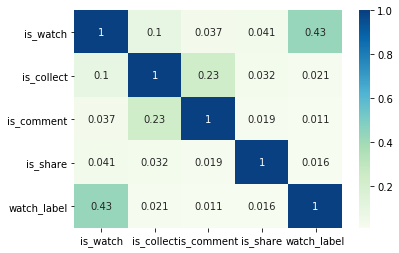

In [19]:
sns.heatmap(label_corr, cmap='GnBu', annot=True)
plt.savefig("label_corr.jpg", dpi=600, bbox_inches='tight')
plt.show()


In [7]:
user_info.head()

,user_id,age,gender,country,province,city,city_level,device_name
0,1757005,3,1,0,9,6,3,327
1,17938,0,0,0,4,22,3,327
2,4263520,1,0,0,19,1,5,327
3,1411600,3,0,0,5,138,1,327
4,3992242,2,0,0,0,142,0,327


In [24]:
video_info.head(10)

,video_id,video_name,video_tags,video_description,video_release_date,video_director_list,video_actor_list,video_score,video_second_class,video_duration
0,3460,脱皮爸爸,"院线电影,家庭关系,命运","中年失意的儿子田力行（古天乐饰）在生活上遇到了重重危机：母亲病逝,工作不顺,妻子要求离婚。正...",2017-04-27,司徒慧焯,"吴镇宇,古天乐,春夏,蔡洁",7.4,"剧情,喜剧,奇幻",5913
1,14553,喜气洋洋小金莲,"古装喜剧,剧情片,喜剧片,内地电影,欢乐喜剧,爱情纠纷",故事始于西门庆为西门药业的“伟哥”产品寻找代言人，西门庆初见潘金莲，一时惊为天人，为成功抱得...,2015-12-30,"杨珊珊,李亚玲","陈南飞,程隆妮,王闯,贾海涛,闫薇儿",5.6,喜剧,6217
2,1214,风流家族,"男女关系,家庭关系,命运,院线电影",香世仁（钟镇涛 饰）是家财万贯的香港富豪，在满足了一切物质上的要求后，他将生活的重心放在了儿...,2002-03-07,"邱礼涛,杨漪珊","张家辉,卢巧音,钟镇涛,叶童,李蕙敏,张坚庭,袁洁莹,黄佩霞,齐芷瑶,刘以达,叶伟信,邹凯光...",6.8,"都市,喜剧,爱情,家庭",5963
3,30639,大提琴的故事,"短片,动画片",低音大提琴演奏家史密斯科夫正要去参加某贵族的沙龙，途中他被河边的美丽景色所吸引，驻足观看。兴...,1949-01-01,"伊里·特恩卡,契诃夫",NaN,NaN,"动画,爱情",17371
4,38522,歌舞大王齐格飞,"喜剧片,人物传记,浪漫爱情",罗伯特．Z．伦纳德导演的这部影片以百老汇最大的歌舞团——齐格菲歌舞团的创办人佛罗伦斯．齐格菲...,1936-04-08,"罗伯特·Z·伦纳德,William Anthony McGuire","威廉·鲍威尔,玛娜·洛伊,路易丝·赖纳,弗兰克·摩根,范妮·布莱斯,弗吉尼亚·布鲁斯,雷吉纳...",7.7,"剧情,歌舞,喜剧",10608
5,50257,一江春水向东流上,"历史,战争,y,yj,yjc,yjcs,yjcsx,yjcsxd,yjcsxdl,yjcsxdls",《一江春水向东流》是由蔡楚生、郑君里导演和编剧，白杨、陶金、上官云珠、舒绣文、吴茵主演的一部...,1947-01-01,"蔡楚生,郑君里","白杨,陶金,舒绣文,上官云珠,吴茵,周伯勋,王静安,顾梦鹤,叶小铿",8.6,"剧情,战争,历史",5765
6,313,俄克拉荷马,"歌舞,西部,爱情",《俄克拉荷马》描写了二十世纪初时发生在美国西部原印第安人居住地的女主角Laurey(劳瑞)和...,1955-06-11,弗雷德·金尼曼,"高登·麦克瑞,格洛丽亚·格雷厄姆,吉恩·纳尔逊,夏洛特·格林伍德,雪莉·琼斯",6.7,"歌舞,西部,爱情",8124
7,3572,来电惊魂-HDR,"来电惊魂,保姆,翻拍,高中生,卡米拉·贝勒,索尼,HDR",在人迹罕至的遥远的别墅里，高中生吉尔和往常一样做兼职保姆，孩子在房子里沉沉的睡着，吉尔关好门...,2006-01-01,"西蒙·韦斯特,Steve Feke,Fred Walton","卡米拉·贝勒,凯蒂·卡西迪,布莱恩·格拉格提,大卫·丹曼,汤米·弗拉纳根,德雷克·德·林特,...",7.0,"惊悚,恐怖",5001
8,17982,摇滚藏獒 AiMax,善与恶;有温度;赤子初心;院线电影,"藏獒波弟在山村长大,本该子承父业担当村庄卫士,却爱上了21世纪摇滚乐。为了追求音乐梦想,他进...",2016-07-08,"艾什·布兰农,郑钧,Kurt Voelker",NaN,7.8,"动画,音乐",5337
9,11269,的士速递-原声版NEW,"电影,喜剧,动作,犯罪,吉拉尔.皮雷,萨米.纳塞利,玛丽昂.歌迪亚,弗雷德里克.迪芬塔尔,艾...",丹尼尔拥有精湛的驾驶技术，警察艾米是个倒霉蛋，两人意外结识，阴差阳错丹尼尔不得不替艾米调查案件,1998-01-01,NaN,"黛西·雷德利,克里夫·欧文,帕特里克·威尔森",NaN,NaN,5060


In [22]:
video_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49731 entries, 0 to 49730
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_id             49731 non-null  int64  
 1   video_name           49722 non-null  object 
 2   video_tags           41831 non-null  object 
 3   video_description    49536 non-null  object 
 4   video_release_date   49061 non-null  object 
 5   video_director_list  38728 non-null  object 
 6   video_actor_list     39543 non-null  object 
 7   video_score          46417 non-null  float64
 8   video_second_class   43821 non-null  object 
 9   video_duration       49731 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 3.8+ MB


In [23]:
video_info.isnull().sum()

video_id                   0
video_name                 9
video_tags              7900
video_description        195
video_release_date       670
video_director_list    11003
video_actor_list       10188
video_score             3314
video_second_class      5910
video_duration             0
dtype: int64